## Demo Processing of Text Data

### Definition of imports

In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, MiniBatchKMeans
#from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt
from time import time
from os import path
from random import shuffle
import glob
import re
from html.parser import HTMLParser
from nltk.corpus import stopwords
from collections import defaultdict
from nltk.stem.porter import PorterStemmer
import copy
import string
import pandas as pd
from tabulate import tabulate

%matplotlib inline

### Specify a random seed

In [2]:
np.random.seed(200)

###  Define constants settings

In [3]:
DATA_PATH = r"C:\Development\Python\AI\Commercial_Projects\HR_System"
HR_DATA_FILENAME = "Start_doing_comments.csv"
HR_DOCS = path.join(DATA_PATH, HR_DATA_FILENAME)

### Load the Corpus data from the source

In [4]:
def load20NewsGroupDocuments():
    categories = ['alt.atheism', 'soc.religion.christian',
              'comp.graphics', 'sci.med']
    twenty_train = fetch_20newsgroups(subset='train',
        categories=categories, shuffle=True, random_state=42)
    docs = twenty_train.data
    num_docs = len(docs)
    print("Loaded the '20 News Group' data with a total of {} documents in the corpus. Data is stores in a list".format(num_docs))
    return docs

def loadDocumentsFromDisc(filename=HR_DOCS):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    docs = text.split('\n')
    shuffle(docs)
    num_docs = len(docs)
    print("Loaded the HR System Data Corpus with a total of {} Number of documents".format(num_docs))
    return docs

raw_docs = loadDocumentsFromDisc()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Development\\Python\\AI\\Commercial_Projects\\HR_System/Start_doing_comments.csv'

### Use basic Natural Language Processing steps to clean-up the Corpus data
Steps will include:
    - Remove non-alpha numeric characters in the corpus documents
    - Set the all the text in the documents to lowercase
    - Stem the text
    - Gets rid of any empty text in each document

In [5]:
def cleanDocApproachOne(in_doc):
    tokens = in_doc.split()
    token_list = []
    stemmer = PorterStemmer()
    regex_non_alphanumeric = re.compile('[^0-9a-zA-Z]')  # REGEX for non alphanumeric chars
    for token in tokens:
        re_punc = re.compile('[%s]' % re.escape(string.punctuation))
        # remove punctuation from each word
        tokens = re_punc.sub(' ', token) 
        token = regex_non_alphanumeric.sub(' ', token)  # Filter text, remove non alphanumeric chars
        token = token.lower()  # Lowercase the text
        token = token.strip()
        #token = stemmer.stem(token)  # Stem the text
        if len(token) < 3:  # If the length of item is lower than 3, remove item
            token = ''
        token_list.append(token)
    out_doc = ' '.join(token_list)
    return out_doc

def cleanDocApproachTwo(in_doc):
    # split into tokens by white space
    tokens = in_doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 3]
    out_doc = ' '.join(tokens)
    return out_doc


def cleanCorpus(docs):
    clone_docs = copy.deepcopy(docs)
    #items_to_clean = set(list(stopwords.words('english')) + ['\n','\n\n','\n\n\n','\n\n\n\n','ocroutput','',' '])
    items_to_clean = set(list(stopwords.words('english')))
    for index, in_doc in enumerate(clone_docs):
        #out_doc = cleanDocApproachOne(in_doc)
        out_doc = cleanDocApproachOne(in_doc)
        clone_docs[index] = out_doc  # Put item back to the list
    cleaned_docs = [elem for elem in clone_docs if elem not in items_to_clean]
    # Remove empty items from the list
    return cleaned_docs

clean_docs = cleanCorpus(raw_docs)
print("raw_docs[:5]:\n{}\n\n".format(raw_docs[:5]))
print("clean_docs[:5]:\n{}\n\n".format(clean_docs[:5]))

NameError: name 'raw_docs' is not defined

### Process the documents text data and vectorize it to a numeric matrix
This step will do the follwing transformations to the data:
    - Tokenize the data
    - Filter of Stopwords
    - Convert the data from text to a numeric feature vector using TF-IDF transformation

In [200]:
def processDoTextAndVectorizeData(docs):
    vectorizer = TfidfVectorizer(max_df=0.5, 
                                 min_df=2, stop_words='english',
                                 use_idf=True)
    X = vectorizer.fit_transform(docs)
    #X = shuffle(X)
    print("Vectorzed the data into numeric TF-IDF matrix of shape: {}".format(X.shape))
    return X, vectorizer
    


### Optionally, improve the performance of the unsupervised learning by reducing data dimensionality
    -  using Truncated Singular Value Decomposition (SVD)

In [201]:
def reduceDataDimensionality(X):
    svd = TruncatedSVD(opts.n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    X = lsa.fit_transform(X)
    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(
        int(explained_variance * 100)))
    return X

### Apply K-Means Clustering algorithm
    - Cluster the data using K-means algorithm (based on a guessed number of clusters) to group the data into categorises

In [202]:
def applyKmeansClustering(X, guess_num_clusters, kmeans_type='classic', is_verbose=True):
    if kmeans_type == 'classic':
        km = KMeans(n_clusters=guess_num_clusters, init='k-means++', max_iter=1000, n_init=1,
                verbose=is_verbose)
    else:
        km = MiniBatchKMeans(n_clusters=guess_num_clusters, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000, verbose=is_verbose)
    print("Clustering sparse data with {}".format(km))
    km.fit(X)
    return km

### Report the Performance of the Clustering Algorithm using Silhouette Coefficient

In [203]:
def reportClusteringPerformance(X, km, data_description="Training"):
    print("Silhouette Coefficient for {0} data: {1:.3f}".format(data_description, metrics.silhouette_score(X, km.labels_, sample_size=1000)))
    print()

### Validate the Clustering Model using unseen validation data

In [204]:
def predictClusters(X, km, docs_valid):
    predicted_clusters = km.predict(X)
    #reportClusteringPerformance(X, km, 'Validation')
    print("First 10 docs have these clusters:\n{}\n\n".format(predicted_clusters[:10]))
    predicted_data = pd.DataFrame(dict(Profile_id = range(len(predicted_clusters)), Document = docs_valid, Cluster = predicted_clusters))
    return predicted_data

### Report the Top terms computed Cluster

In [205]:
def reportTopTermsOfComputedClusters(km, vectorizer, guess_num_clusters):
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names()
    for i in range(guess_num_clusters):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind], end='')
        print()

### Finding the optimal number of clusters using the 'Elbow' method

In [206]:
def findOptimalNumberOfClusters(X, total_num_clusters, kmeans_type='classic', is_verbose=False):
    t0 = time()
    distortions = []
    for i in range(1, total_num_clusters):
        if kmeans_type == 'classic':
            km = KMeans(n_clusters=i, init='k-means++', max_iter=10000, n_init=1,
                    verbose=is_verbose)
        else:
            km = MiniBatchKMeans(n_clusters=i, init='k-means++', n_init=1,
                             init_size=1000, batch_size=1000, verbose=is_verbose)
        km.fit(X)
        distortions.append(km.inertia_)
    def plotElbow():
        plt.plot(range(1, total_num_clusters), distortions, marker='o')
        plt.title("Elbow Plot of Clustering Algorithm")
        plt.xlabel("Number of Clusters")
        plt.ylabel("Distortions")
        plt.show()
    t1 = time()
    elasped_time = t1 - t0
    print("Search for optimal number of clusters took {0:.3f} seconds".format(elasped_time))
    plotElbow()
            

In [207]:
def getClusterData(model, data, clusters, 
                     feature_names, num_clusters,
                     topn_features=10):

    cluster_details = {}  
    # get cluster centroids
    ordered_centroids = model.cluster_centers_.argsort()[:, ::-1]
    # get key features for each cluster
    # get movies belonging to each cluster
    for cluster_num in range(num_clusters):
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster_num'] = cluster_num
        key_features = [feature_names[index] 
                        for index 
                        in ordered_centroids[cluster_num, :topn_features]]
        cluster_details[cluster_num]['key_features'] = key_features
        
        profiles = movie_data[movie_data['Cluster'] == cluster_num]['Profile_ID'].values.tolist()
        cluster_details[cluster_num]['Documents'] = movies
    
    return cluster_details
        
       
    
def print_cluster_data(cluster_data):
    # print cluster details
    for cluster_num, cluster_details in cluster_data.items():
        print('Cluster {} details:'.format(cluster_num))
        print('-'*20)
        print('Key features:', cluster_details['key_features'])
        print('Movies in this cluster:')
        print(', '.join(cluster_details['movies']))
        print('='*40)

### Main Loop of the Data Clustering Process


Starting 8 Data Clustering Steps..


1. Load the Documents from the disc
Loaded the HR System Data Corpus with a total of 10156 Number of documents
2. Process the documents text data and vectorize it to a numeric matrix
Vectorzed the data into numeric TF-IDF matrix of shape: (10156, 2705)
3. Optionally, improve the performance of the unsupervised learning by reducing data dimensionality
4. Split data into train and validation sets
5. Cluster the data using K-means algorithm (based on a guessed number of clusters) to group the data into categorises
Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=5, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=True)
Initialization complete
Iteration  0, inertia 714.112
Iteration  1, inertia 704.386
Converged at iteration 1: center shift 0.000000e+00 within tolerance 3.420417e-08
6. Report the Performance of the Clustering Algorithm on the Trai

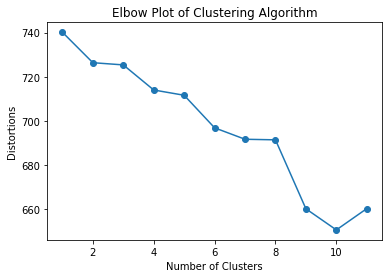

In [208]:
def mainLoop():
    np.random.seed(100)
    total_num_clusters = 12
    guess_num_clusters = 5
    is_reduce_dim = False    
    kmeans_algo_type = 'classic'
    num_train_samples = 800
    t0 = time()
    print("Starting 8 Data Clustering Steps..\n\n")
    print("1. Load the Documents from the disc")
    #docs = loadDocumentsFromDisc()
    raw_docs = loadDocumentsFromDisc()
    docs = cleanCorpus(raw_docs)
    print("2. Process the documents text data and vectorize it to a numeric matrix")
    X, vectorizer = processDoTextAndVectorizeData(docs)
    print("3. Optionally, improve the performance of the unsupervised learning by reducing data dimensionality")
    if is_reduce_dim:
        reduceDataDimensionality(X)
    print("4. Split data into train and validation sets")
    X_train = X[:num_train_samples]
    X_valid = X[num_train_samples:]
    print("5. Cluster the data using K-means algorithm (based on a guessed number of clusters) to group the data into categorises")
    km = applyKmeansClustering(X_train, guess_num_clusters)
    print("6. Report the Performance of the Clustering Algorithm on the Training Data using Silhouette Coefficient")
    reportClusteringPerformance(X_train, km)
    print("7. Predict the Clusters running the tained model on unseen validation data")
    predicted_data = predictClusters(X_valid, km, docs[num_train_samples:])
    print("predicted_data.head(10) = \n{}\n".format(predicted_data.head(10)))
    #print(tabulate(predicted_data.head(10), headers='keys', tablefmt='psql'))
    print("8. Report the Top terms computed Cluster")
    reportTopTermsOfComputedClusters(km, vectorizer, guess_num_clusters)
    t1 = time()
    elasped_time = t1 - t0
    print("Clustering process took {0:.3f} seconds".format(elasped_time))
    print("")
    findOptimalNumberOfClusters(X_train, total_num_clusters)
    return km, predicted_data

km, predicted_data = mainLoop()

In [ ]:
getClusterData(model, data, clusters, feature_names, num_clusters)